In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RZGate
from collections import defaultdict

In [7]:
# helper functions
def gray_code(n: int):
    return [i ^ (i >> 1) for i in range(1 << n)]

def _fwht(vec: np.ndarray) -> np.ndarray:
    
    y = vec.astype(float).copy()
    h, N = 1, y.size
    while h < N:
        for i in range(0, N, h*2):
            for j in range(i, i+h):
                u, v = y[j], y[j+h]
                y[j], y[j+h] = u+v, u-v
        h <<= 1
    return y

def Walsh_coefficients(matrix: np.ndarray) -> np.ndarray:
    
    assert matrix.ndim == 2 and matrix.shape[0] == matrix.shape[1]
    N = matrix.shape[0]
    assert N & (N-1) == 0 and N > 0
    
    d = np.diag(matrix)
    assert np.allclose(matrix, np.diag(d))
    assert np.allclose(np.abs(d), 1.0, atol=1e-12)

    f = np.angle(d)   
    a = _fwht(f) / N
    return a


In [ ]:
def build_optimal_walsh_circuit(matrix):

    aj = np.real(Walsh_coefficients(matrix)) # get aj's for the 2**n diagonal
    n = int(np.log2(len(aj)))
    qc = QuantumCircuit(n)

    gray_seq = gray_code(n)
    groups = defaultdict(list)
    for j in gray_seq:
        if j == 0:
            continue  # skip a0
        target = j.bit_length() - 1
        groups[target].append(j)

    def controls_of(j, target):

        return [q for q in range(n) if ((j >> q) & 1) and q != target]

    EPS = 1e-12        # ignore small rotations

    for target in sorted(groups):
        seq = groups[target]
        if not seq:
            continue

    
        j0 = seq[0]
        theta0 = -2.0 * aj[j0]
        current = set(controls_of(j0, target))  
      
        for c in current:
            qc.cx(c, target)
        if abs(theta0) >= EPS:
            qc.append(RZGate(theta0), [target])

        prev = j0

        
        for j in seq[1:]:
            theta = -2.0 * aj[j]
            diff = prev ^ j                    
            flip = diff.bit_length() - 1        
            if flip != target:
                qc.cx(flip, target)
               
                if flip in current:
                    current.remove(flip)
                else:
                    current.add(flip)

            if abs(theta) >= EPS:
                qc.append(RZGate(theta), [target])

            prev = j

        for c in sorted(current, reverse=True):
            qc.cx(c, target)

    return qc


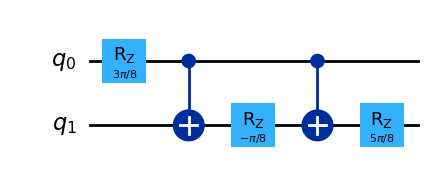

In [ ]:
# two qubit test
phases_2q = np.array([0, np.pi/4, np.pi/2, np.pi])
diagU_2q = np.diag(np.exp(1j * phases_2q))
qc=build_optimal_walsh_circuit(diagU_2q)
qc.draw('mpl')

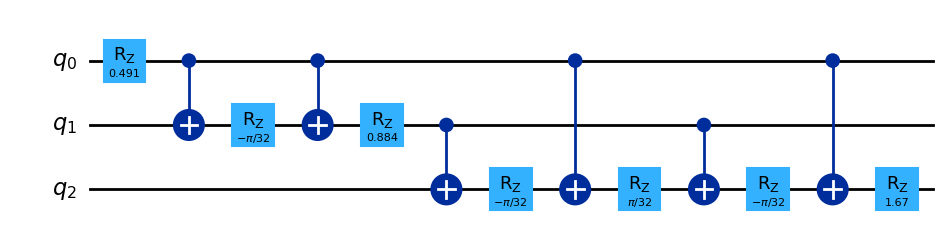

In [ ]:
# 3 qubit test
phases_3q = np.array([
    0,           
    np.pi/8,     
    np.pi/4,     
    3*np.pi/8,   
    np.pi/2,     
    5*np.pi/8,   
    3*np.pi/4,   
    np.pi        
], dtype=float)

diagU_3q = np.diag(np.exp(1j * phases_3q))
qc_3q = build_optimal_walsh_circuit(diagU_3q)
qc_3q.draw('mpl')


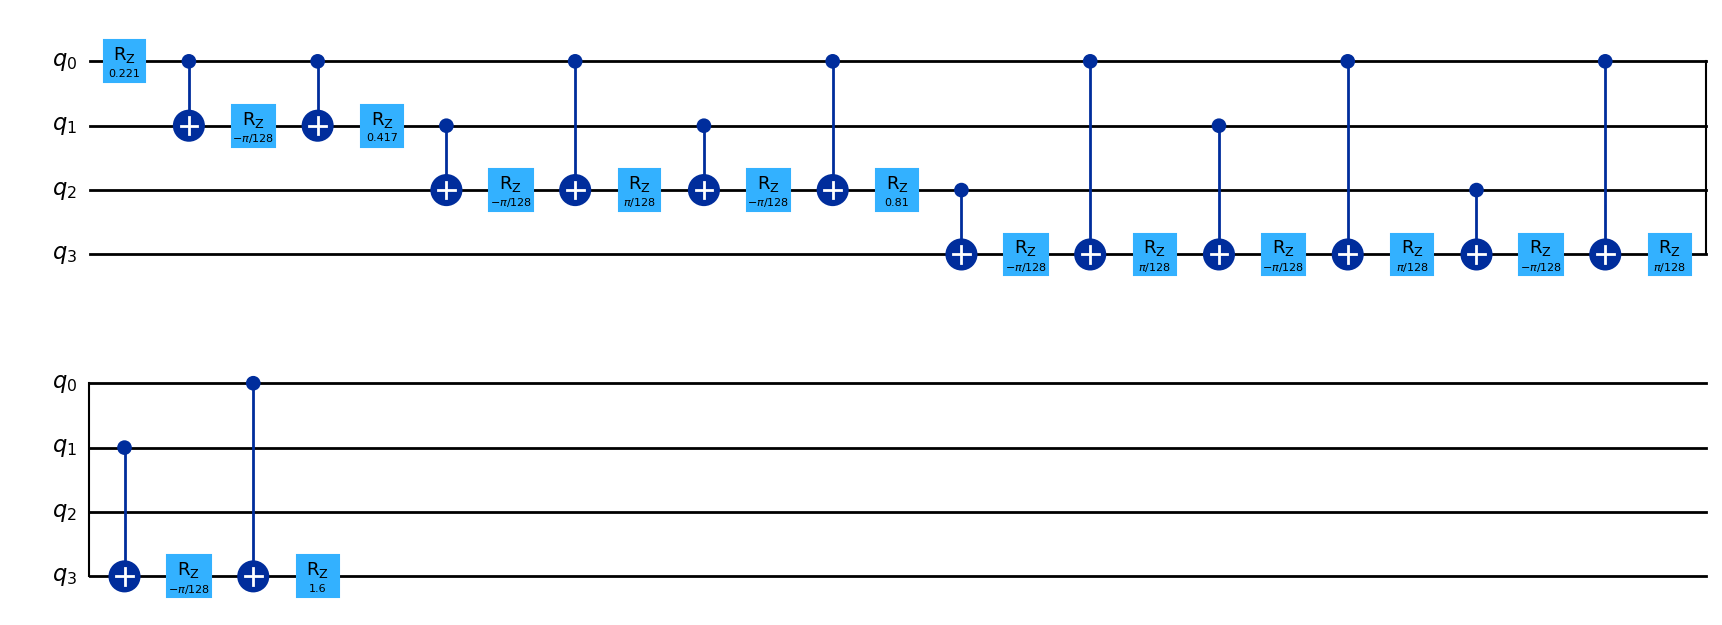

In [12]:
# 4 qubit test
phases_4q = np.array([
    0,
    np.pi/16,
    np.pi/8,
    3*np.pi/16,
    np.pi/4,
    5*np.pi/16,
    3*np.pi/8,
    7*np.pi/16,
    np.pi/2,
    9*np.pi/16,
    5*np.pi/8,
    11*np.pi/16,
    3*np.pi/4,
    13*np.pi/16,
    7*np.pi/8,
    np.pi
], dtype=float)

diagU_4q = np.diag(np.exp(1j * phases_4q))
qc_4q = build_optimal_walsh_circuit(diagU_4q)
qc_4q.draw('mpl')
